# Results and figure generation of "Echo State and Band-pass Networks with aqueous memristors: leaky reservoir computing with a leaky substrate"

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyontronics import EchoStateNetwork,GinfActivator, visualize_reservoir, BandPassNetwork

ginf_activator = GinfActivator(V_min=-2, V_max=2, resolution=200, offset=True)


def mse(test, predictions):
    return np.mean((predictions - test) ** 2)

def nrmse(test, predictions):
    return np.sqrt(np.mean((predictions - test) ** 2))/(max(test.T[0])-min(test.T[0]))

In [2]:
def MackeyGlassGenerator(tau=17, n=1000, beta=0.2, gamma=0.1, n_samples=5000, dt=1.0, seed=None):
    """
    Generate Mackey-Glass time series
    Parameters:
    tau (int): Time delay
    n (int): Number of points to generate
    beta, gamma (float): Equation parameters
    n_samples (int): Number of samples to keep
    dt (float): Time step size
    """
    if seed:
        np.random.seed(seed)

    history_len = tau * 1
    values = np.random.rand(history_len + n)

    #values[:history_len] = 1.1

    delay_steps = int(tau / dt)
    if delay_steps <= 0:
        delay_steps = 1

    for t in range(history_len, history_len + n - 1):
        x_tau = values[t - delay_steps]
        dx_dt = beta * x_tau / (1 + x_tau**10) - gamma * values[t]
        values[t + 1] = values[t] + dx_dt * dt

    return values[history_len : history_len + n_samples]

## Steady State Conductance Activator

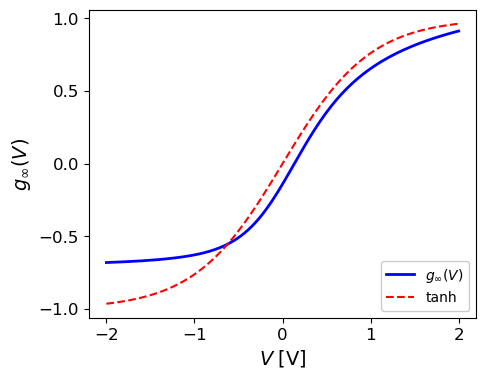

In [4]:
lookup_table = ginf_activator.get_lookup_table()

in_array = np.linspace(-2, 2, 100) 
out_array = np.tanh(in_array) 

plt.figure(figsize=(5, 4))
plt.plot(
    lookup_table[0],
    lookup_table[1],
    label=r"$g_{\infty}(V)$",
    color="blue",
    linewidth=2,
)
plt.plot(in_array, out_array, linestyle="--",label="tanh", alpha=1, color='red')
plt.xlabel(r"$V \;[\text{V}]$", fontsize=14)
plt.ylabel(r"$g_{\infty}(V)$", fontsize=14)
#plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(np.arange(-2,2.5,1),fontsize=12)
plt.yticks(np.arange(-1,1.05,0.5),fontsize=12)
plt.legend(loc='lower right',framealpha=1)
plt.savefig("output/ginf_activator_plot.pdf",bbox_inches='tight')
plt.savefig("output/ginf_activator_plot.png",bbox_inches='tight')

## ESN with Mackey-Glass time series

In [8]:
# Generate Mackey-Glass time series for train and test sets
mg_dt = 1
mg_series = MackeyGlassGenerator(tau=17, n=100000, n_samples=50000, dt=mg_dt)
mg_series_test = MackeyGlassGenerator(tau=17, n=10000, n_samples=5000, dt=mg_dt)

# Normalize data between -1 and 1
# mg_series = 2 * (mg_series - mg_series.min()) / (mg_series.max() - mg_series.min()) - 1
# mg_series_test = 2 * (mg_series_test - mg_series_test.min()) / (mg_series_test.max() - mg_series_test.min()) - 1
mg_series = np.tanh(mg_series-1)
mg_series_test = np.tanh(mg_series_test-1)

# Create input/output pairs for time series prediction
inputs = mg_series[:-1].reshape(-1, 1)
targets = mg_series[1:].reshape(-1, 1)

inputs_test = mg_series_test[:-1].reshape(-1, 1)
targets_test = mg_series_test[1:].reshape(-1, 1)

# Prepare train and test sets of desired lengths
train_len = 40000
test_len = 4000
train_inputs = inputs[:train_len]
train_targets = targets[:train_len]
test_inputs = inputs_test[:test_len]
test_targets = targets_test[:test_len]

In [10]:
mse_mean = 0
test_num = 1
for i in range(test_num):
    esn = EchoStateNetwork(
        input_dim=1,
        reservoir_size=400,
        output_dim=1,
        leaking_rate=0.95,
        step_size=mg_dt,
        time_scale=1/0.44,
        spectral_radius=0.95,
        sparsity=0.75,
        input_scaling=0.5,
        regularization=1e-6,
        washout = round(train_len/400),
        activation=ginf_activator.activate,
        guarantee_ESP=False,
        progress_bar=False,
    )
    
    # Train on first part of series
    esn.fit(train_inputs, train_targets)
    
    # Generate predictions on test set
    teacher_ratio = 0.2
    predictions_mg = esn.predict(test_inputs, teacher_ratio=teacher_ratio)

    mse_mean += (test_targets[883,0]-predictions_mg[883,0])**2/test_num
    
# Calculate prediction error after network settled from np.zeroes initialization
rmse_mean = np.sqrt(mse_mean)

#print(f"{nrmse(test_targets, predictions) = }")
print('{0:.16f}'.format(rmse_mean))
print(f"{esn.physical_length = }")
teacher_mode = int(len(test_targets)*teacher_ratio)
print(f"{teacher_mode = } out of {len(test_targets)}")

This initilization might not have the echo state property
0.0009797766257656
esn.physical_length = 169.43474841747155
teacher_mode = 800 out of 4000


In [11]:
bpn = BandPassNetwork(
    input_dim=1,
    reservoir_size=100,
    output_dim=1,
    leaking_rate=0.9,
    step_size=mg_dt,
    time_scale=1/0.45,
    time_scale_std=0.4,
    spectral_radius=0.9,
    sparsity=0.85,
    input_scaling=0.5,
    regularization=1e-6,
    washout = round(train_len/400),
    activation=ginf_activator.activate,
    guarantee_ESP=False,
)

# Train on first part of series
bpn.fit(train_inputs, train_targets)

# Generate predictions on test set
teacher_ratio = 0.2
predictions = bpn.predict(test_inputs, teacher_ratio=teacher_ratio)

# Calculate prediction error after network settled from np.zeroes initialization
print(f"{mse(test_targets, predictions) = }")

print(f"{esn.physical_length = }")
teacher_mode = int(len(test_targets)*teacher_ratio)
print(f"{teacher_mode = } out of {len(test_targets)}")

This initilization might not have the echo state property


Training (time-step): 100%|██████████| 40100/40100 [00:00<00:00, 49585.47it/s]


mse(test_targets, predictions) = 0.06867117330255387
esn.physical_length = 169.43474841747155
teacher_mode = 800 out of 4000


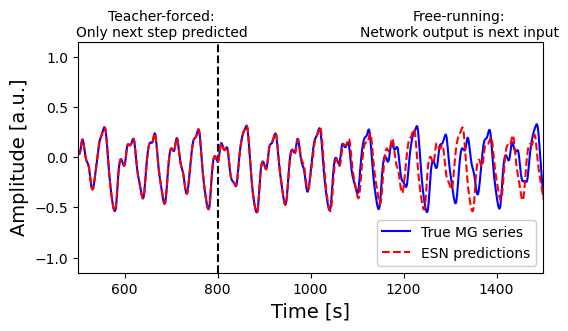

In [14]:
cutoff_min = 500
cutoff_max = 1500

plt.figure(figsize=(6, 3))
plt.axvline(x=teacher_mode, linestyle="--", color='black')
plt.text(cutoff_min+180, 1.2, 'Teacher-forced:\nOnly next step predicted', dict(size=10), horizontalalignment='center')
plt.text(cutoff_max-180, 1.2, 'Free-running:\nNetwork output is next input', dict(size=10), horizontalalignment='center')
plt.plot(test_targets, label="True MG series", alpha=1, color='blue')
plt.plot(predictions_mg, label="ESN predictions", linestyle="--", alpha=1, color='red')
# plt.title("Mackey-Glass Time Series Prediction (First 400 Steps)")
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude [a.u.]", fontsize=14)
plt.xlim(cutoff_min, cutoff_max)
plt.ylim(-1.15, 1.15)
plt.legend(loc='lower right',framealpha=1)
plt.savefig("output/mg_prediction_plot.pdf",bbox_inches='tight')
plt.savefig("output/mg_prediction_plot.png",bbox_inches='tight')

In [17]:
#visualize_reservoir(esn)

## ESN with Harmonic Wave time series

In [269]:
# Generate synthetic data (simple sine wave prediction)
t = np.linspace(0, 80 * np.pi, 800)
dt_harmonic = 80 * np.pi/800
data_bpntest = np.sin(t) * np.cos(1.2*t)

# Create input/output pairs for time series prediction
inputs_bpntest = data_bpntest[:-1].reshape(-1, 1)
targets_bpntest = data_bpntest[1:].reshape(-1, 1)

(-1.15, 1.15)

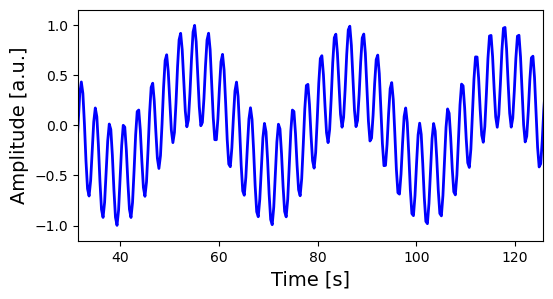

In [271]:
cutoff_min = 100*dt_harmonic
cutoff_max = 400*dt_harmonic

plt.figure(figsize=(6, 3))
plt.plot(t,data_bpntest, label="True signal",color='blue',linewidth=2)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude [a.u.]", fontsize=14)
plt.xlim(cutoff_min, cutoff_max)
plt.ylim(-1.15, 1.15)

In [287]:
# Initialize and train ESN
mse_mean = 0
test_num = 100
for i in range(test_num):
    esn = EchoStateNetwork(
        input_dim=1,
        reservoir_size=12,
        output_dim=1,
        leaking_rate=0.44,
        step_size=dt_harmonic,
        time_scale=1.87,
        spectral_radius=0.32,
        sparsity=0.67,
        input_scaling=0.26,
        regularization=4e-5,
        washout=0,
        activation=ginf_activator.activate,
        progress_bar=False,
        guarantee_ESP=True,
    )
    
    # Train on synthetic data
    esn.fit(inputs_bpntest, targets_bpntest)
    
    # Generate predictions
    teacher_ratio=0.25
    predictions = esn.predict(inputs_bpntest, teacher_ratio=teacher_ratio)
    if mse(targets_bpntest[200:799,0], predictions[200:799,0])<4:
        mse_mean += mse(targets_bpntest[200:799,0], predictions[200:799,0])/test_num
    # Calculate prediction error after network settled from np.zeroes initialization
    #print(f"{mse(targets, predictions) = }")

rmse_mean_harmonic_esn = np.sqrt(mse_mean)
teacher_mode = int(len(targets_bpntest)*teacher_ratio)
print(f"{teacher_mode = }")
print(mse_mean)

teacher_mode = 199
0.14478323506758428


In [280]:
# Initialize and train BPN
mse_mean = 0
test_num = 100
for i in range(test_num):
    bpn = BandPassNetwork(
        input_dim=1,
        reservoir_size=12,
        output_dim=1,
        leaking_rate=0.86,
        step_size=dt_harmonic,
        time_scale=2.79,
        time_scale_std=9.9,
        spectral_radius=0.76,
        sparsity=0.35,
        input_scaling=0.21,
        regularization=1e-6,
        washout=0,
        activation=ginf_activator.activate,
        weight_seed = 1,
        progress_bar=False,
    )
    # Train on synthetic data
    bpn.fit(inputs_bpntest, targets_bpntest)
    
    # Generate predictions
    teacher_ratio=0.25
    bpn_predictions = bpn.predict(inputs_bpntest, teacher_ratio=teacher_ratio)
    if mse(targets_bpntest[200:799,0], bpn_predictions[200:799,0])<4:
        mse_mean += mse(targets_bpntest[200:799,0], bpn_predictions[200:799,0])/test_num
    # Calculate prediction error after network settled from np.zeroes initialization
    #print(f"{mse(targets, bpn_predictions) = }")

rmse_mean_harmonic_bpn = np.sqrt(mse_mean)
teacher_mode = int(len(targets_bpntest)*teacher_ratio)
print(f"{teacher_mode = }")
print(mse_mean)

teacher_mode = 199
0.09664015935066315


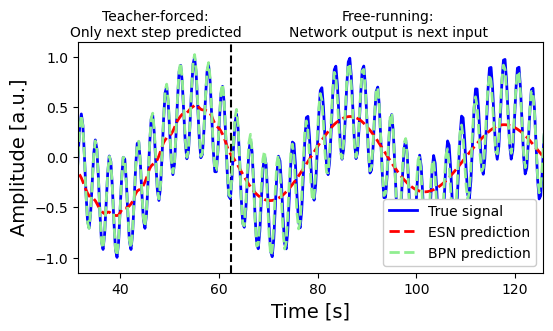

In [281]:
cutoff_min = 100*dt_harmonic
cutoff_max = 400*dt_harmonic

plt.figure(figsize=(6, 3))
plt.axvline(x=teacher_mode*dt_harmonic, linestyle="--", color='black')
plt.text(cutoff_min+50*dt_harmonic, 1.2, 'Teacher-forced:\nOnly next step predicted', dict(size=10), horizontalalignment='center')
plt.text(cutoff_max-100*dt_harmonic, 1.2, 'Free-running:\nNetwork output is next input', dict(size=10), horizontalalignment='center')
plt.plot(t,data_bpntest, label="True signal",color='blue',linewidth=2)
plt.plot(t[1:],predictions.T[0], label="ESN prediction", linestyle="--",color='red',linewidth=2)
plt.plot(t[1:],bpn_predictions.T[0], label="BPN prediction", linestyle="--",color='lightgreen',linewidth=2)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude [a.u.]", fontsize=14)
plt.xlim(cutoff_min, cutoff_max)
plt.ylim(-1.15, 1.15)
plt.legend(loc='lower right',framealpha=1)
plt.savefig("output/harmonic2_prediction_plot.pdf",bbox_inches='tight')
plt.savefig("output/harmonic2_prediction_plot.png",bbox_inches='tight')

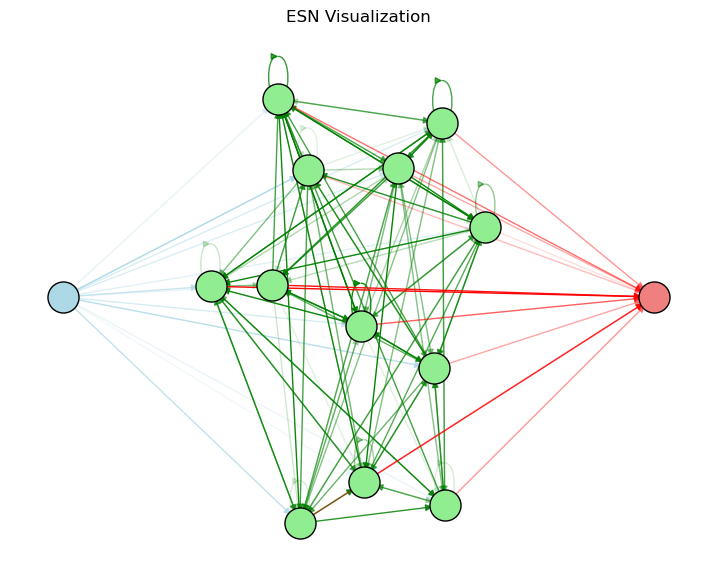

In [264]:
visualize_reservoir(bpn)

## ESN with Ventilator Pressure Prediction data

In [110]:
import pandas as pd
from pyontronics import BandPassNetwork

In [112]:
data = pd.read_csv(r"data\ventilator-pressure-prediction\train.csv")[:100000]

#data = data.to_dummies(columns=["R", "C"])

split = int(len(data) * 0.8)
predict_steps = 3

# Data for pressure prediction
train_x = data[["pressure"]][0:split-predict_steps].to_numpy()
train_y = data[["pressure"]][predict_steps:split].to_numpy()
test_x = data[["pressure"]][split:len(data)-predict_steps].to_numpy()
test_y = data[["pressure"]][split+predict_steps:len(data)].to_numpy()

#data.drop('id','breath_id',"pressure")[:split].head()

In [113]:
# Data for expiratory valve open or closed
train_x_uout = data[["pressure"]][:split].to_numpy()
train_y_uout = data[["u_out"]][:split].to_numpy()
test_x_uout = data[["pressure"]][split:].to_numpy()
test_y_uout = data[["u_out"]][split:].to_numpy()

In [54]:
mse_mean = 0
test_num = 20
for i in range(test_num):
    esn = EchoStateNetwork(
        input_dim=train_x.shape[1],
        reservoir_size=28,
        output_dim=train_y.shape[1],
        leaking_rate=0.66,
        step_size=0.034035,
        time_scale=0.15,
        spectral_radius=0.16,
        sparsity=0.75,
        input_scaling=0.1,
        regularization=0.00047855525,
        washout = 100,
        activation=ginf_activator.activate,
        guarantee_ESP=True,
        progress_bar=False,
    )
    
    esn.fit(train_x_uout, train_y_uout)
    
    predictions = np.round(esn.predict(test_x_uout, teacher_ratio=1),0)
    #print(f"Test MSE: {mse(test_y_uout, predictions)}")
    mse_mean += mse(test_y_uout, predictions)/test_num

print(mse_mean)

0.10044000000000002


In [72]:
test_num = 20
mse_mean = 0
mse_list = np.zeros(test_num)

for i in range(test_num):
    bpn = BandPassNetwork(
        input_dim=train_x.shape[1],
        reservoir_size=7,
        output_dim=train_y.shape[1],
        leaking_rate=0.66,
        step_size=0.034035,
        time_scale=0.075,
        time_scale_std=0.35,
        spectral_radius=0.5,
        sparsity=0.75,
        input_scaling=0.1,
        regularization=0.00047855525,
        washout = 100,
        activation=ginf_activator.activate,
        guarantee_ESP=True,
        progress_bar=False,
    )
    
    bpn.fit(train_x_uout, train_y_uout)
    
    predictions_uout = np.round(bpn.predict(test_x_uout, teacher_ratio=1),0)
    #print(f"Test MSE: {mse(test_y_uout, predictions_uout)}")
    mse_list[i] = mse(test_y_uout, predictions_uout)
    mse_mean += mse(test_y_uout, predictions_uout)/test_num

print(min(mse_list))
print(mse_mean)

0.0943
0.10722999999999998


In [ ]:
visualize_reservoir(bpn)

In [138]:
bpn = BandPassNetwork(
    input_dim=train_x.shape[1],
    reservoir_size=200,
    output_dim=train_y.shape[1],
    leaking_rate=0.66,
    step_size=0.034035,
    time_scale=0.1,
    time_scale_std=0.5,
    spectral_radius=0.5,
    sparsity=0.95,
    input_scaling=0.1,
    regularization=0.00047855525,
    washout = 100,
    activation=ginf_activator.activate,
    guarantee_ESP=True,
    progress_bar=True,
)
    
bpn.fit(train_x, train_y)
    
predictions_p = np.round(bpn.predict(test_x, teacher_ratio=1),0)
print(f"Test RMSE: {np.sqrt(mse(test_y, predictions_p))}")

Training (time-step): 100%|██████████| 80097/80097 [00:02<00:00, 39161.36it/s]


Test RMSE: 2.993188156305847


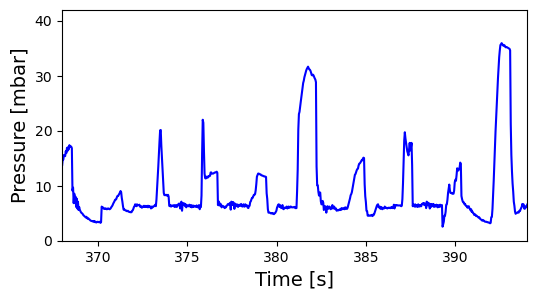

In [50]:
plt.figure(figsize=(6, 3))
plt.plot(np.linspace(0, len(test_y)*0.034035, len(test_y)), test_y*0.980665,color='blue')
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Pressure [mbar]", fontsize=14)
plt.xlim(368,394)
plt.ylim(0, 42)
#plt.legend()
#plt.show()
plt.savefig("output/ventilator_pressureinput_plot.pdf",bbox_inches='tight')

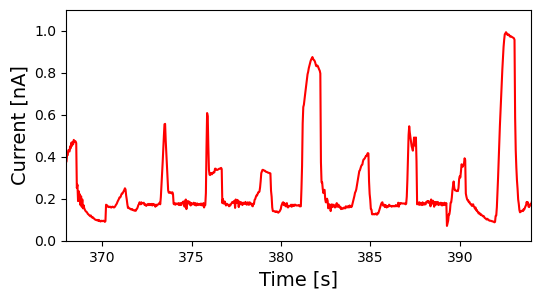

In [51]:
L = 200*10**-6
R = 25*10**-6
epsilon = (8.8541878128*10**-12)*80.23
eta = 0.001009347337765476 
psi0 = -0.04

plt.figure(figsize=(6, 3))
plt.plot(np.linspace(0, len(test_y)*0.034035, len(test_y)), -np.pi*(R**2)*epsilon*psi0*(test_y*0.980665*100)*10**9/(eta*L),color='red')
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Current [nA]", fontsize=14)
plt.xlim(368,394)
plt.ylim(0, 1.1)
#plt.legend()
#plt.show()
plt.savefig("output/ventilator_currentinput_plot.pdf",bbox_inches='tight')

In [52]:
L = 200*10**-6
R = 25*10**-6
epsilon = (8.8541878128*10**-12)*80.23
eta = 0.001009347337765476 
psi0 = -0.04
print(0.1/(-np.pi*(R**2)*epsilon*0.980665*psi0*100*10**9/(eta*L)))

3.6895598405076244


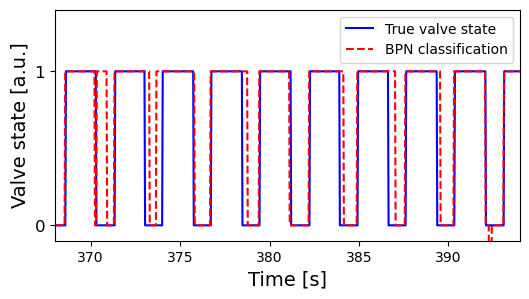

In [53]:
plt.figure(figsize=(6, 3))
plt.plot(np.linspace(0, len(test_y_uout)*0.034035, len(test_y_uout)), test_y_uout,color='blue', label="True valve state")
plt.plot(np.linspace(0, len(test_y[predict_steps:])*0.034035, len(test_y_uout)), predictions_uout,color='red', label="BPN classification", linestyle="--",)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Valve state [a.u.]", fontsize=14)
plt.yticks(np.arange(0,1.1,1),fontsize=12)
plt.xlim(368,394)
plt.ylim(-0.1,1.4)
plt.legend()
#plt.show()
plt.savefig("output/ventilator_plot_uout.pdf",bbox_inches='tight')

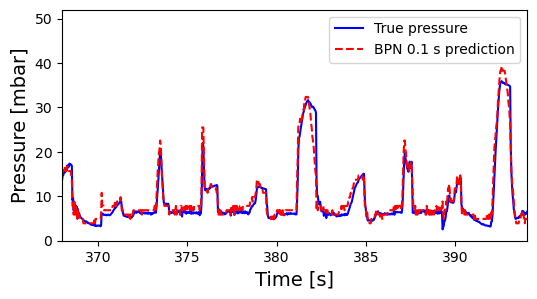

In [54]:
plt.figure(figsize=(6, 3))
plt.plot(np.linspace(0, len(test_y)*0.034035, len(test_y)), test_y*0.980665,color='blue', label="True pressure")
plt.plot(np.linspace(0, len(test_y[predict_steps:])*0.034035, len(test_y[predict_steps:])), predictions_p[predict_steps:]*0.980665,color='red', label="BPN 0.1 s prediction", linestyle="--",)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Pressure [mbar]", fontsize=14)
plt.xlim(368,394)
plt.ylim(0, 52)
plt.legend()
#plt.show()
plt.savefig("output/ventilator_plot_pressure.pdf",bbox_inches='tight')

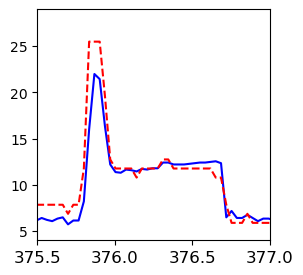

In [55]:
plt.figure(figsize=(3, 3))
plt.plot(np.linspace(0, len(test_y)*0.034035, len(test_y)), test_y*0.980665,color='blue')
plt.plot(np.linspace(0, len(test_y[predict_steps:])*0.034035, len(test_y[predict_steps:])), predictions_p[predict_steps:]*0.980665,color='red', linestyle="--",)
#plt.xlabel("Time [s]", fontsize=14)
#plt.ylabel("Pressure [mbar]", fontsize=14)
plt.xticks(np.arange(374,379,0.5),fontsize=12)
plt.xlim(375.5,377)
plt.ylim(4, 29)
#plt.show()
plt.savefig("output/ventilator_plot_zoom.pdf",bbox_inches='tight')

## Linear Autoregression comparison of ventilator data

In [118]:
from pyontronics import LinearAutoregression

t = np.linspace(0, len(train_x)*0.034035, len(train_x))

# Split data
train_p, test_p = (train_x.T)[0], (test_x.T)[0]
train_v, test_v = train_y_uout, test_y_uout

# Pressure prediction task
print("=== Pressure Prediction ===")
ar_model_p = LinearAutoregression(window_size=200, lookback_stride=1, prediction_horizon=3)
ar_model_p.train_pressure_prediction(train_p)
mse, r = ar_model_p.evaluate_pressure(test_p)
print(f"Window: {ar_model_p.window_size}, Stride: {ar_model_p.lookback_stride}")
print(f"MSE: {mse:.4f}, RMSE: {np.sqrt(mse):.4f}, Correlation: {r:.4f}")

# Valve classification task
print("\n=== Valve Classification ===")
ar_model = LinearAutoregression(window_size=8, lookback_stride=7)
ar_model.train_valve_classification(train_p, train_v)
acc = ar_model.evaluate_valve(test_p, test_v)
print(f"Window: {ar_model.window_size}, Stride: {ar_model.lookback_stride}")
print(f"Accuracy: {acc:.4f}")

=== Pressure Prediction ===
Window: 200, Stride: 1
MSE: 10.4796, RMSE: 3.2372, Correlation: 0.9237

=== Valve Classification ===
Window: 8, Stride: 7
Accuracy: 0.9039


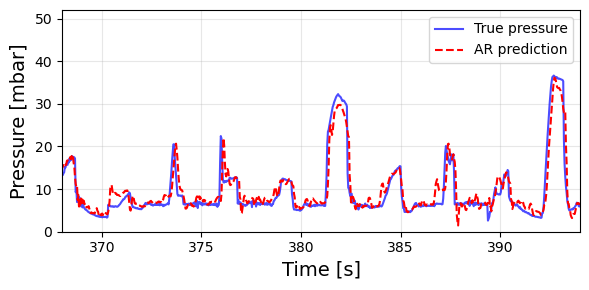

In [158]:
# Generate predictions for plotting pressures
pressure_predictions = ar_model_p.predict_pressure(test_p)

# Calculate time axis - make sure it matches test_p length
total_samples = len(test_p)
time_axis_full = np.linspace(0, total_samples*0.034035, total_samples)

# 1. Pressure Prediction Plot
plt.figure(figsize=(6, 3))
pred_start_idx = ar_model_p.window_size * ar_model_p.lookback_stride + ar_model_p.prediction_horizon - 1
plt.plot(time_axis_full, test_p, color='blue', label="True pressure", alpha=0.7)
plt.plot(time_axis_full[pred_start_idx:], 
         pressure_predictions, 
         color='red', 
         label="AR prediction",
         linestyle="--",
         linewidth=1.5)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Pressure [mbar]", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(368,394)
plt.ylim(0, 52)
plt.tight_layout()
plt.show()

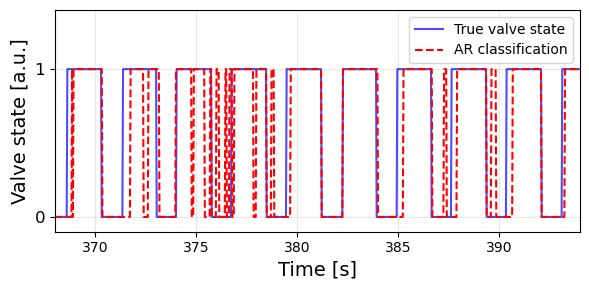

In [160]:
# Generate predictions for plotting valve state
valve_predictions = ar_model.predict_valve_state(test_p)

# Valve State Classification Plot
plt.figure(figsize=(6, 3))
classif_start_idx = ar_model.window_size * ar_model.lookback_stride

# Trim test_v to match the plotting range
test_v_trimmed = test_v[:len(time_axis_full)]  # Ensure same length as time axis
test_v_flat = test_v_trimmed.flatten() if test_v_trimmed.ndim > 1 else test_v_trimmed

plt.plot(time_axis_full, test_v_flat, color='blue', label="True valve state", alpha=0.7)
plt.plot(time_axis_full[classif_start_idx:], 
         valve_predictions[:len(time_axis_full[classif_start_idx:])],  # Ensure matching length
         color='red', 
         label="AR classification",
         linestyle="--",
         linewidth=1.5)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Valve state [a.u.]", fontsize=14)
plt.yticks(np.arange(0,1.1,1),fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(368,394)
plt.ylim(-0.1,1.4)
plt.tight_layout()
plt.show()